Particle-hopping models, formulated usually in terms of cellular automata (CA), have been used to study the spatio-temporal organization in systems of interacting particles driven far from equilibrium which include, for example, vehicular traffic. In
general, the inter-particle interactions tend to hinder their motions so that the average speed decreases monotonically with the increasing density of the particles. A known counterexample is the motion of ants in a trail, where the average speed of the particles varies non-monotonically with their density because of the coupling of their
dynamics with another dynamical variable, the pheromone released by the ants.

In this notebook, we will explore a CA model which may be interpreted as a model of unidirectional flow in an ant trail. The models which will be described in the following assume the existence of a fully developed ant trail on which a steady flow takes place, so the formation of the trail will not be covered.

### UNIDIRECTIONAL TRAFFIC ON A SINGLE LANE ANT TRAIL

#### ASYMMETRIC SIMPLE EXCLUSION MODEL

First, let's introduce the *Asymmetric Simple Excusion Process* (ASEP), a model used to study transport phenomena. It represents particles moving on a one-dimensional lattice with exclusion and biased hopping rules, so it can be interpreted as a cellular automaton model.

Key Features of ASEP:

**- Lattice Structure:** The system consists of a one-dimensional lattice of discrete sites. Each site can be either occupied by a particle or empty.

**- Exclusion Rule:** No two particles can occupy the same site at the same time. This is the "simple exclusion" condition.

**- Asymmetric Motion:** Particles move to neighboring sites (left, right) with asymmetric probabilities (in our case, they can move only in one direction, e.g. to the right).

**- Executing Movement:** Particles attempt to move to a neighboring site at each time step, and the action succedes if the target site is empty.


An important distinction regards the boundary of the lattice, since it has a finite dimention:

**- Periodic Boundary Conditions:** The last site connects to the first site, forming a ring.

**- Open Boundary Conditions:** Particles can enter and leave the system at the boundaries with specified rates.

#### ANT TRAIL MODEL

The *Ant Trail Model* (ATM) was introduced in 2002 by Chowdhury and extends the ASEP, identifying particles as ants and incorporating pheromone-mediated interactions between the ants. This means that lattice sites now contain info regarding the presence of an ant and the presence of pheromone. The figure below shows an example of an update procedure in this model:

- for every ant, the probability of hopping to the next state is computed, and it's higher if there's pheromone ahead of them

- the positions of the ants are then updated accordingly

- pheromones are added on the sites containing an ant, whereas on other sites pheromones evaporate with a certain probability

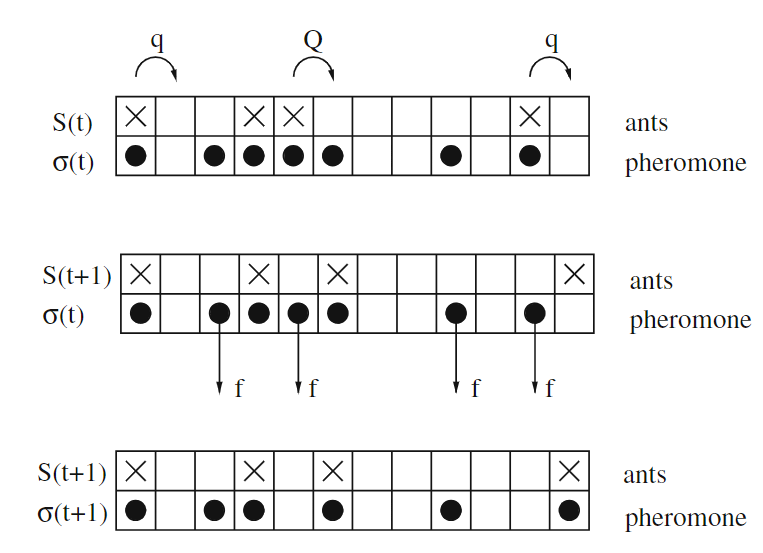

Considering a periodic boundary, the rules that update ant positions and pheromones in a discrete time model are as follows:
$$
\begin{cases}
S_j(t+1) = S_j(t) + min( \eta _{j-1}(t), S_{j-1}(t), 1 - S_j(t) ) - min( \eta_j(t), S_j(t), 1-S_{j+1}(t) ) \\
\sigma_j(t+1) = max( S_j(t+1), min( \sigma_j(t), \xi_j(t) ) )
\end{cases}
$$

Where $\xi$ and $\eta$ are stochastic variables defined as follows:
$$
\xi_j(t) = 
\begin{cases}
0\ with\ probability\ f \\
1\ with\ probability\ 1 - f
\end{cases} \\
\eta_j(t) = 
\begin{cases}
1\ with\ probability\ p = q + (Q-q)*\sigma_{j+1}(t) \\
0\ with\ probability\ 1-p
\end{cases}
$$

So $\xi$ governs the evaporation of pheromones on unoccupied sites, while $\eta$ is used to model the probabillity of an ant to move to the next site, which is different wether the next state contains pheromone or not. We can note that this model can be reduced to the ASEP if $p$ becomes constant,in the cases where $f=1$ ($p=q$) or $f=0$ ($p=Q$).

Now let's try to implement this model in code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
# Random number generator used later
rng = np.random.default_rng()

In [ ]:
class ATM():
    """
    Class that implements a 1D cellular automata to simulate unidirectional traffic of ants in a single lane, with periodic boundaries

    Parameters for initialization:
        - L (int) : integer defining length of the latice
        - rho (float) : density of ants in the lattice 
        - Q (float) : probability for an ant to move to a site with pheromones
        - q (float) : probability for an ant to move to a site without pheromones
        - f (float) : probability of pheromones to evaporate after a time step

    Functions given to the user:
        - simulate : function that runs the simulation and computes significant data
                
    """
    

    def __init__(self, L, rho, Q, q, f):
        self._len = L
        self._lattice = np.zeros(shape=(2,L))
        self._initialize_ants( int(rho * L) )
        self._rho = rho
        self._Q = Q
        self._q = q
        self._f = f
        self._flow = 0
        self._time_avg_speed = 0
        # Function to account for periodic boundary while indexing
        self._idx = lambda i : (i + self._len) % self._len

    def _initialize_ants(self, N):
        # Populates the lattice with ants proportionally to density given
        ant_positions = rng.choice(self._len, N, replace=False)
        for pos in ant_positions:
            self._lattice[0, pos] = 1
            self._lattice[1, pos] = 1

    def _update_state(self):
        new = np.empty(shape=(2, self._len))
        # Update all ants
        eta = [ rng.uniform(0,1) < (self._q + (self._Q - self._q) * self._lattice[1, self._idx(j+1)]) for j in range(self._len)]
        for i in range(self._len):
            new[0,i] = self._lattice[0,i] + \
                min( eta[self._idx(i-1)], self._lattice[0, self._idx(i-1)], 1 - self._lattice[0,i] ) - \
                min( eta[i], self._lattice[0,i], 1 - self._lattice[0, self._idx(i+1)] )
        # Update all pheromones 
        for i in range(self._len):
            new[1,i] = max( new[0,i] , min( self._lattice[1,i], (rng.uniform(0,1) < (1-self._f)) ) )
        self._lattice = copy.copy(new)

    def _avg_speed(self):
        ant_pos = np.where(self._lattice[0,:] == 1)[0]
        V = [0 if self._lattice[0, self._idx(i+1)] == 1 else self._q + (self._Q - self._q) * self._lattice[1, self._idx(i+1)] for i in ant_pos]
        return sum(V) / len(V)

    def simulate(self, setup, itr, plot = False):
        """
        Simulate motion of ants for the time steps given

        Parameters:
        - setup (int) : number of time steps to compute before the measurements begin
        - itr (int) : representing the number  of time steps used to average the measures
        - plot (boolean) : flag that allows for the printing of the spatial-temporal behavior of ants
        """

        log = [] # Data for plotting, populated if needed
        if plot:
            log = np.empty( shape=(setup + itr, self._len), dtype=int )
        for i in range(setup):
            self._update_state()
            if plot:
                log[i,:] = self._lattice[0,:]

        itr_spd = np.zeros(itr) # Compute average speed (after the setup) for every step
        for i in range(itr):
            itr_spd[i] = self._avg_speed()
            self._update_state()
            if plot:
                log[i+setup,:] = self._lattice[0,:]
            
        self._time_avg_speed = sum(itr_spd) / itr
        self._flow = self._rho * self._time_avg_speed # J = rho * v  hydrodinamic relation

        if plot:
            # Plotting the space-time diagram
            plt.figure()
            plt.imshow(log, cmap='gray_r', aspect='auto', origin='upper')
            plt.xlabel("Position (x)")
            plt.ylabel("Time (t)")
            plt.title("Spatial-Temporal Behavior of Ants")
            plt.figtext(0.15, 1., f'L = {self._len}  rho = {self._rho}  Q = {self._Q}  q = {self._q}  f = {self._f}\nAvg Speed = {self._time_avg_speed:.4f}  Flow = {self._flow:.4f}', bbox=dict(facecolor='white', alpha=0.5))
            plt.show()


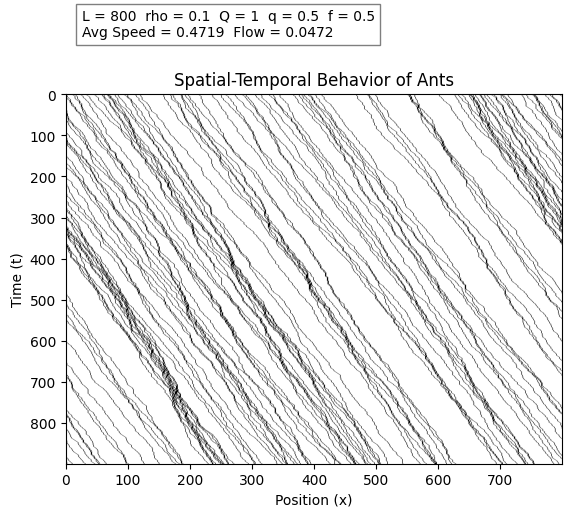

In [ ]:
plot = True
test = ATM(800, 0.1, 1, 0.5, 0.5)
test.simulate(300, 600, plot)

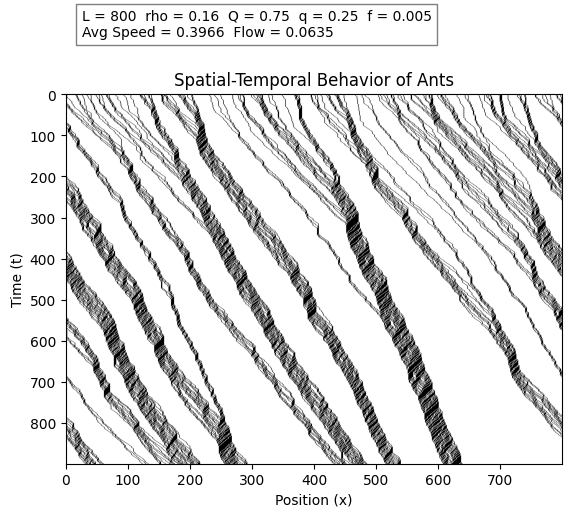

In [ ]:
plot = True
test = ATM(800, .16, 0.75, 0.25, 0.005)
test.simulate(300, 600, plot)

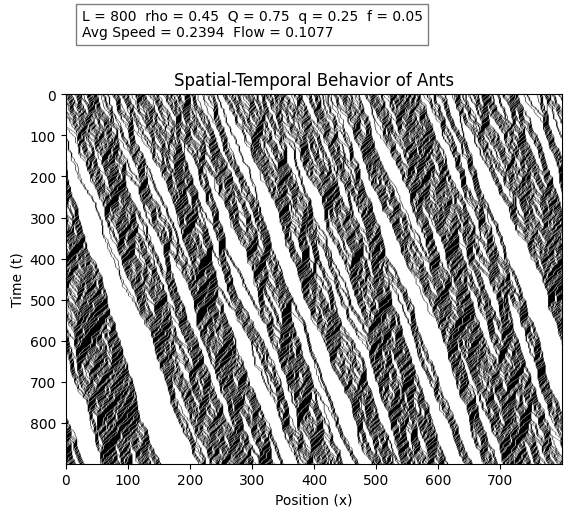

In [ ]:
plot = True
test = ATM(800, .45, 0.75, 0.25, 0.05)
test.simulate(300, 600, plot)

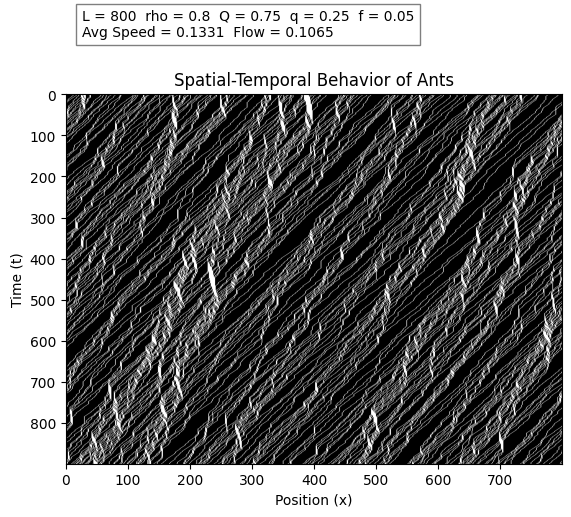

In [ ]:
plot = True
test = ATM(800, .8, 0.75, 0.25, 0.05)
test.simulate(300, 600, plot)

In the graphs abowe we can see examples of the behaviour of ants under different conditions:

- in the first image, a low density of ants and high pheromone evaporation rate lead ants to have very little interactions;

- in the second graph, low density of ants and high permanence of pheromone allow for low density clusters to form;

- the last two examples show how increasing the density of ants leads to crowded trails, lowering the average speed of the ants without major benefits to flow;

- in the last graph, given the high density of ants that makes them slow down to critical levels, so much that one could ignore the rightwards movement of ants to focus on the leftwards movement of the empty spaces; this is a concept that will come in handy later in this notebook. 

We can visualize the changes in flow and speed in our model using the most important quantity of interest in the context of flow properties of the traffic models: **the fundamental diagram**, representing the flow-versus-density relation, where flow is the product of the density and the average speed.

Using the parameters of the models above, we can make this plots using different values of $f$ to see how pheromones activity influences thhe behavior of ants.

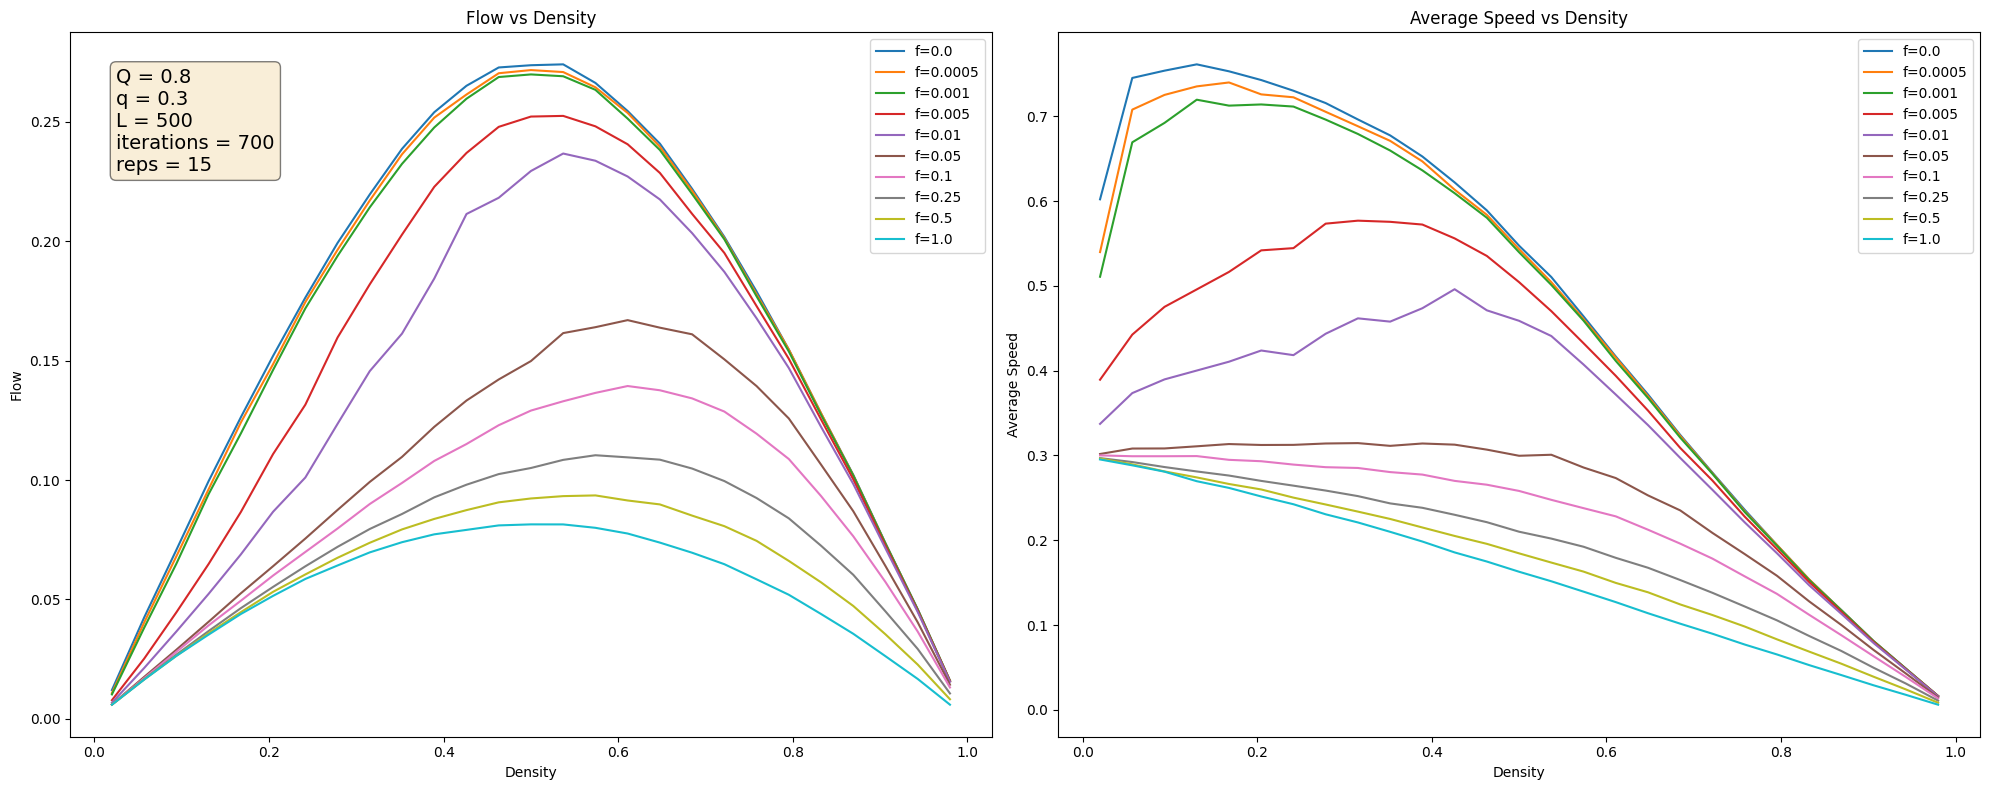

In [18]:
test_f = np.array([0, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 1])
test_rho = np.linspace(0.02, 0.98, 27)
L = 500#input("Length of trail:\n")
Q = 0.8#input("Step probability Q:\n")
q = 0.3#input("Step probability q:\n")
setup = 100#input("Number of trail setup iterations:\n")
iterations = 600#input("Number of measured iterations:\n")
reps = 15#input("Number of repetitions for redundancy:\n")
plot = False

data = np.empty(shape=(2, len(test_rho) * len(test_f)))
tmp = np.empty(shape=(2, reps))
for i,f in enumerate(test_f):
    for j,rho in enumerate(test_rho):
        for k in range(reps): # "anti-aliasing"
            model = ATM(L, rho, Q, q, f)
            model.simulate(setup, iterations, plot)
            tmp[0,k] = model._flow
            tmp[1,k] = model._time_avg_speed
        data[0, j + len(test_rho) * i] = sum(tmp[0,:])/reps
        data[1, j + len(test_rho) * i] =  sum(tmp[1,:])/reps

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for i, f in enumerate(test_f):
    ax1.plot(test_rho, data[0, i*len(test_rho):(i+1)*len(test_rho)], label=f'f={f}')
    ax2.plot(test_rho, data[1, i*len(test_rho):(i+1)*len(test_rho)], label=f'f={f}')

ax1.set_xlabel('Density')
ax1.set_ylabel('Flow')
ax1.set_title('Flow vs Density')
ax1.legend()

ax2.set_xlabel('Density')
ax2.set_ylabel('Average Speed')
ax2.set_title('Average Speed vs Density')
ax2.legend()

textstr = f'Q = {Q}\nq = {q}\nL = {L}\niterations = {setup + iterations}\nreps = {reps}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

### ANALYTICAL RESULTS

An exact solution for the stationary state of this ant-trail model has been hard to find because of the inherent fluctuations in the total amount of pheromones along the ant trail, which influence ant movement making the average velocity exibit non-monotonic behavior with ant density.

In absence of an exact solution, two approximate theories have been proposed. The first utilizes a **mean-field approach**. However, this
method encounters limitations in the intermediate density regime, where dynamics are governed by loose clusters that cannot be accurately represented by mean-field theories.

The second approach involves mapping the system onto a **zero-range process** (ZRP), as the model’s dynamics closely resemble those of a ZRP. This mapping identifies particles (ants) with the sites of the ZRP, while the gaps between the ants correspond to the particles of the ZRP.

In 2024 a paper called *[An Exactly Solvable Model for Single-Lane Unidirectional Ant Traffic]* started from a model proposed by Belitsky and Schutz for the RNA Polymerase, which captures fluctuations of this kind, and adapted it to the single-lane unidirectional ant traffic to find an exact solution.

Let's focus on this new model and try to simulate it. 

#### ANT TRAIL MODEL - ENHANCED VERSION

Before we write the equations of the model, let's introduce the concepts that will be used from now on.

As in the previous model, instead of exploring the emergence of ant trails, the focus is on observing ant traffic on an already estabilished trail. Unlike the previous model, which employs parallel dynamics, this model utilizes a random-sequential update rule. The exclusion principle is preserved, and a more complex rule is estabilished for interactions among ants. Lastly, in this model ants move from right to left, and as a consequence empty spaces move from left to right.

**TYPES OF PARTICLES**

In this model the following particles are considered:
- 0 : particle representing a site with an ant
- 1 : particle representing an empty site
- 2 : particle representing a site without ant but containing pheromone

In this context, motion alligns with the movement of empty sites:
$$
\begin{cases}
10 \to 02\ \ \ with\ rate\ q \\
20 \to 02\ \ \ with\ rate\ Q \\
2 \to 1\ \ \ \ \ \ \ with\ rate\ f
\end{cases}
$$
Note that these relations are the same as the previous model.

In the following we will model motion in the trail using information regarding empty sites, so particles of type 1 and 2.

**ANT INTERACTIONS**

Given the focus on the collective movement of ants, we will assume periodic boundary conditions on our lattice composed of $L$ sites. Considering that there are $L−N$ ants on this lattice, where $N$ represents the total number of particles of types 1 and 2, we represent a system configuration as $\eta= (\eta_1,...,\eta_L)$, where $\eta_j\in \{0,1,2\} \ for\ j=1,...,L$, signifying an allowed arrangement of particles.

This model assumes that the transition rates depends on the surrounding environment, so the transition rates written above are functions of the current state:

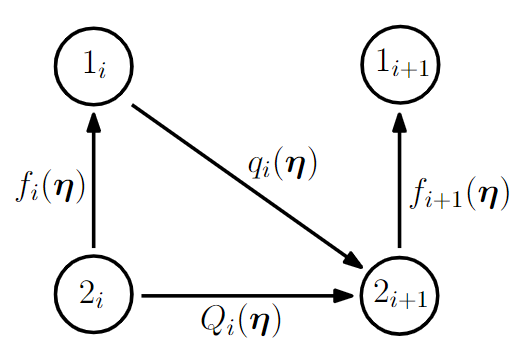

In the following, an allowed configuration $\eta$ will be defined using two vectors:
- a position vectior $x=(x_1,...,x_N)$ , where $x_i$ represents the coordinate of particle $i$ inside the lattice
- a state vector $s=(s_1,...,s_N)$ , where $s_i$ represents the type (0,1) of particle $i$

The advantage of employing the position vector lies in its ability to express the distance between two particles using the Kronecker-$\delta$ function, defined as follows:
$$
\delta_{u,v}=
\begin{cases}
1\ if\ u=v\\
0\ if\ u\neq v
\end{cases}
$$

Now we are in a position to state the rates influenced by the surrounding environment:

$$
\begin{cases}
q_i(\eta)= \delta_{s_i,1}q(1+\delta_{x_i+2,x_{i+1}}q^{*01})(1-\delta_{x_i+1,x_{i+1}}) \\
Q_i(\eta)= \delta_{s_i,2}Q(1+\delta_{x_i+2,x_{i+1}}Q^{*01})(1-\delta_{x_i+1,x_{i+1}}) \\
f_i(\eta)= \delta_{s_i,2}f(1+ \delta_{x_{i-1},x_i-1}f^{1*}+\delta_{x_{i+1},x_i+1}f^{*1}+\delta_{x_{i-1},x_i-2}f^{10*}+\delta_{x_{i+1},x_i+2}f^{*01})
\end{cases}
$$

**NEIGHBORING-EFFECT PARAMETERS**

In this new model the basic transition rates $Q,\ q,\ f$ are updated considering neighbors of the current particle, and the added parameters allow to model the particles behaviour in various cases; for example, if an ant has another ant right behind it, we might want to model the push from behind and move the ant ahead faster, so while updating $Q$ and $q$ we decrease these rates if right after an ant there is no other ant (all this is transposed to be modelled considering the empty spaces instead of the sites containing ants).

**PERSONAL CHANGES**

In order to make this model's parameter easier to interpret, I'm going to change the equations a little bit while mantaining the general idea of the parameters introducted. This will make it so that I won't be able to use the authors' mathematical results to compute flow and velocity, so I'll resort to the previous model's general equations to compute them.

$$
\begin{cases}
q_i(\eta)= \delta_{s_i,1}(q+\delta_{x_i+2,x_{i+1}}q^{*01})(1-\delta_{x_i+1,x_{i+1}}) \\
Q_i(\eta)= \delta_{s_i,2}(Q+\delta_{x_i+2,x_{i+1}}Q^{*01})(1-\delta_{x_i+1,x_{i+1}}) \\
f_i(\eta)= \delta_{s_i,2}(f+\delta_{x_{i-1},x_i-1}f^{1*}+\delta_{x_{i+1},x_i+1}f^{*1}+\delta_{x_{i-1},x_i-2}f^{10*}+\delta_{x_{i+1},x_i+2}f^{*01})
\end{cases}
$$

Now the new parameters are simply added or subtracted to the result, giving a more intuitive understanding on how they change the interactions of ants. Of course we'll have to be cautious to make the transition rates remain in the interval $[0,1]$ so that they keep having a meaning as probabilities.

Below this last simplified model is implemented.

In [2]:
class ATM_v2():
    def __init__(self, L, rho, Q, q, f, Q01, q01, f_1, f1_, f_01, f10_):
        self._len = L
        self._lattice = np.zeros(L, dtype=int) # vector s (type of particles) is extracted from the lattice using coordinates of vector x
        self._n_particles = L - int(rho * L)
        self._x = np.empty(self._n_particles, dtype=int)
        self._initialize_sites( self._n_particles )
        self._rho = rho
        self._Q = Q
        self._q = q
        self._f = f
        # All the new parameters introduced in this model
        self._Q01 = Q01
        self._q01 = q01
        self._f_1 = f_1
        self._f1_ = f1_
        self._f_01 = f_01
        self._f10_ = f10_
        # Function to account for periodic boundary while indexing
        self._idx = lambda i, l : (i + l) % l
        self._flow = 0
        self._avg_speed = 0

    def _initialize_sites(self, N):
        # Populates the lattice with ants proportionally to density given
        empty_positions = rng.choice(self._len, N, replace=False)
        for pos in empty_positions:
            self._lattice[pos] = 1 + (rng.uniform(0,1) < 0.5) # Randomly add pheromones to empty sites
        i = 0
        for idx, particle in enumerate(self._lattice):
            if particle != 0:
                self._x[i] = idx
                i += 1

    def _q_rate(self, s, i):
        return np.clip((s == 1) * (self._q + ((self._idx(self._x[i]+2,self._len)) == (self._x[self._idx(i+1,self._n_particles)])) * self._q01) * (1 - ((self._idx(self._x[i]+1,self._len)) == (self._x[self._idx(i+1,self._n_particles)]))), a_min=0, a_max=1)

    def _Q_rate(self, s, i):
        return np.clip((s == 2) * (self._Q + ((self._idx(self._x[i]+2,self._len)) == (self._x[self._idx(i+1,self._n_particles)])) * self._Q01) * (1 - ((self._idx(self._x[i]+1,self._len)) == (self._x[self._idx(i+1,self._n_particles)]))), a_min=0, a_max=1)

    def _f_rate(self, s, i):
        return np.clip((s == 2) * (self._f + ((self._x[self._idx(i-1,self._n_particles)])==(self._idx(self._x[i]-1,self._len)))*self._f1_ + ((self._x[self._idx(i+1,self._n_particles)])==(self._idx(self._x[i]+1,self._len)))*self._f_1 + ((self._x[self._idx(i-1,self._n_particles)])==(self._idx(self._x[i]-2,self._len)))*self._f10_ + ((self._x[self._idx(i+1,self._n_particles)])==(self._idx(self._x[i]+2,self._len)))*self._f_01), a_min=0, a_max=1)

    def _update_state(self):
        #print('BEGIN UPDATING')
        for i in np.random.permutation([i for i in range(self._n_particles)]): # Random sequential update
            s = self._lattice[self._x[i]] # Current type of particle
            #print(f'i={i}, particle with coordinate {self._x[i]} which is of type {s}')
            # Compute transition rates for ith particle
            q = self._q_rate(s, i)
            Q = self._Q_rate(s, i)
            f = self._f_rate(s, i)
            #print(f'q = {q} Q = {Q} f = {f}\nlattice: {self._lattice}   x: {self._x} (before checks)')
            # Totally empty site
            if ( s == 1 ) and ( rng.uniform(0,1) < q ):
                #print('q happened')
                self._lattice[self._x[i]] = 0
                self._lattice[self._idx(self._x[i]+1, self._len)] = 2
                self._x[i] = self._idx(self._x[i]+1, self._len)
            # Empty site with pheromone
            if ( s == 2 ):
                if ( rng.uniform(0,1) < Q ): # Check for ant movement coming into current site
                    #print('Q happened')
                    self._lattice[self._x[i]] = 0
                    self._lattice[self._idx(self._x[i]+1, self._len)] = 2
                    self._x[i] = self._idx(self._x[i]+1, self._len)
                elif ( rng.uniform(0,1) < f ): # Check for evaporation of pheromone if no ant moved in
                    #print('f happened')
                    self._lattice[self._x[i]] = 1
            #print(f'lattice: {self._lattice}   x: {self._x} (after checks)\n- - - - -')

    def _compute_avg_spd(self):
        # Indexes of sites preceding ants that are particles (1,2)
        pos = np.intersect1d(np.vectorize(lambda i: self._idx(i-1, self._len))(np.where(self._lattice == 0)[0]), self._x)
        # Indexes of these sites transposed in vector x
        pos = [np.where(self._x == i)[0] for i in pos]
        V = [self._q_rate(self._lattice[self._x[i]], i) * (2 - self._lattice[self._x[i]]) + self._Q_rate(self._lattice[self._x[i]], i)  * (self._lattice[self._x[i]] - 1) for i in pos]
        return sum(V) / self._len

    def simulate(self, setup, itr, plot = False):
        """
        Simulate motion of ants for the time steps given

        Parameters:
        - setup (int) : number of time steps to compute before the measurements begin
        - itr (int) : representing the number  of time steps used to average the measures
        - plot (boolean) : flag that allows for the printing of the spatial-temporal behavior of ants
        """
        log = [] # Data for plotting, populated if needed
        if plot:
            log = np.empty( shape=(setup + itr, self._len), dtype=int )
        for i in range(setup):
            self._update_state()
            if plot:
                log[i,:] = np.where(self._lattice == 0, 0, 1)

        itr_spd = np.zeros(itr) # Compute average speed (after the setup) for every step
        for i in range(itr):
            itr_spd[i] = self._compute_avg_spd()
            self._update_state()
            if plot:
                log[i+setup,:] = np.where(self._lattice == 0, 0, 1)
            
        self._avg_speed = sum(itr_spd) / itr
        self._flow = self._avg_speed * self._rho

        if plot:
            # Plotting the space-time diagram
            plt.figure()
            plt.imshow(log, cmap='gray', aspect='auto', origin='upper')
            plt.xlabel("Position (x)")
            plt.ylabel("Time (t)")
            plt.title("Spatial-Temporal Behavior of Ants")
            figtxt = f'L={self._len}   rho={self._rho}   Q={self._Q}   q={self._q}   f={self._f}\nQ01={self._Q01}   q01={self._q01}   f_1={self._f_1}   f1_={self._f1_}   f_01={self._f_01}   f10_={self._f10_}\nAvg Speed={self._avg_speed:.6f}   Flow={self._flow:.6f}'
            plt.figtext(0.15, 1., figtxt, bbox=dict(boxstyle='round',facecolor='wheat', alpha=0.5))
            plt.show()
        

C:\Users\test1\AppData\Local\Temp\ipykernel_23712\3212136487.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  itr_spd[i] = self._compute_avg_spd()


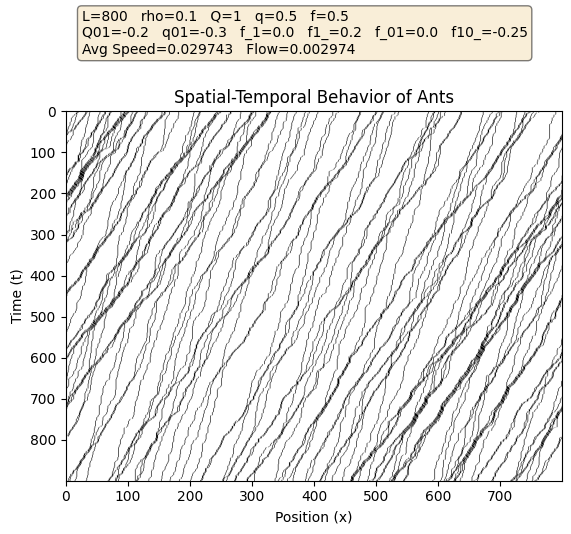

In [170]:
plot = True
L, rho, Q, q, f = 800, 0.1, 1, 0.5, 0.5
Q01, q01, f_1, f1_, f_01, f10_ = -0.2, -0.3, 0.0, 0.2, 0.0, -0.25
test = ATM_v2(L, rho, Q, q, f, Q01, q01, f_1, f1_, f_01, f10_)
test.simulate(200, 700, plot)

C:\Users\test1\AppData\Local\Temp\ipykernel_23712\3212136487.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  itr_spd[i] = self._compute_avg_spd()


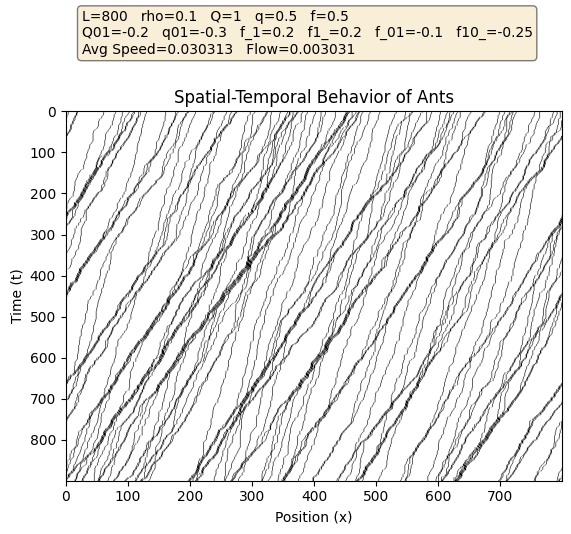

In [171]:
plot = True
L, rho, Q, q, f = 800, 0.1, 1, 0.5, 0.5
Q01, q01, f_1, f1_, f_01, f10_ = -0.2, -0.3, 0.2, 0.2, -0.1, -0.25
test = ATM_v2(L, rho, Q, q, f, Q01, q01, f_1, f1_, f_01, f10_)
test.simulate(200, 700, plot)

C:\Users\test1\AppData\Local\Temp\ipykernel_23712\3212136487.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  itr_spd[i] = self._compute_avg_spd()


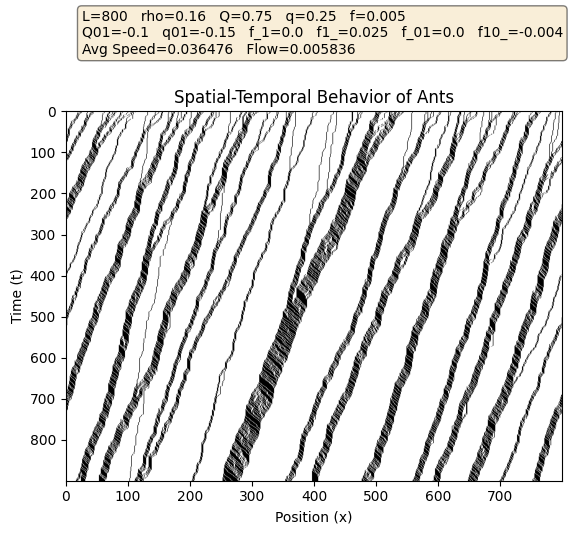

In [172]:
plot = True
L, rho, Q, q, f = 800, 0.16, 0.75, 0.25, 0.005
Q01, q01, f_1, f1_, f_01, f10_ = -0.1, -0.15, 0.0, 0.025, 0.0, -0.004
test = ATM_v2(L, rho, Q, q, f, Q01, q01, f_1, f1_, f_01, f10_)
test.simulate(200, 700, plot)

C:\Users\test1\AppData\Local\Temp\ipykernel_23712\3212136487.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  itr_spd[i] = self._compute_avg_spd()


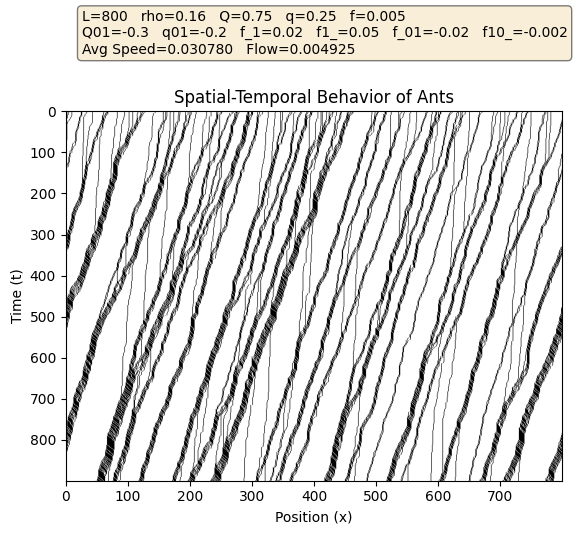

In [173]:
plot = True
L, rho, Q, q, f = 800, 0.16, 0.75, 0.25, 0.005
Q01, q01, f_1, f1_, f_01, f10_ = -0.3, -0.2, 0.02, 0.05, -0.02, -0.002
test = ATM_v2(L, rho, Q, q, f, Q01, q01, f_1, f1_, f_01, f10_)
test.simulate(200, 700, plot)

C:\Users\test1\AppData\Local\Temp\ipykernel_23712\3212136487.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  itr_spd[i] = self._compute_avg_spd()


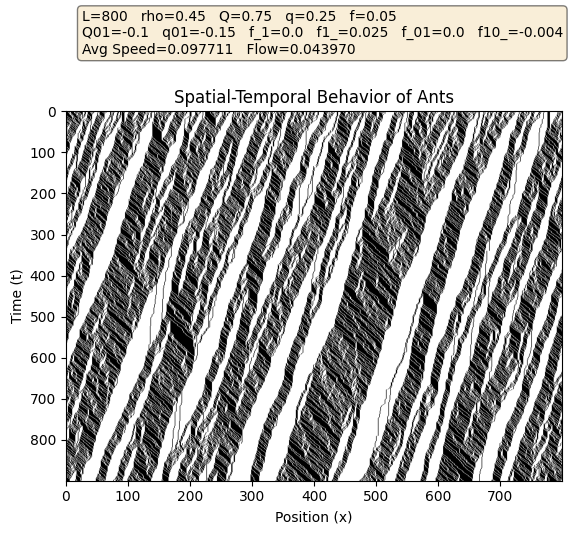

In [174]:
plot = True
L, rho, Q, q, f = 800, .45, 0.75, 0.25, 0.05
Q01, q01, f_1, f1_, f_01, f10_ = -0.1, -0.15, 0.0, 0.025, 0.0, -0.004
test = ATM_v2(L, rho, Q, q, f, Q01, q01, f_1, f1_, f_01, f10_)
test.simulate(200, 700, plot)

C:\Users\test1\AppData\Local\Temp\ipykernel_23712\3212136487.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  itr_spd[i] = self._compute_avg_spd()


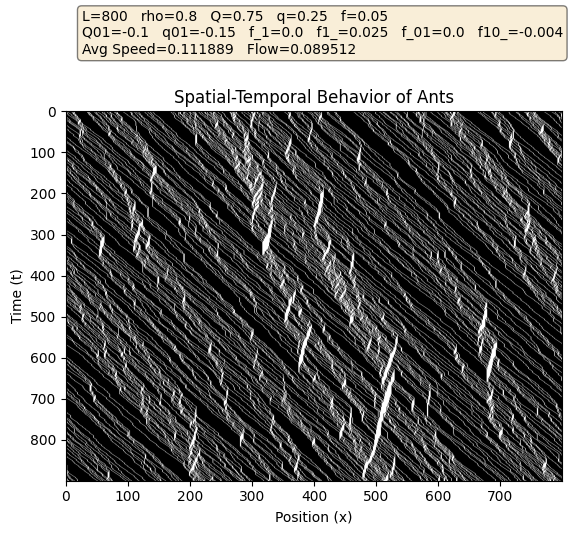

In [175]:
plot = True
L, rho, Q, q, f = 800, .8, 0.75, 0.25, 0.05
Q01, q01, f_1, f1_, f_01, f10_ = -0.1, -0.15, 0.0, 0.025, 0.0, -0.004
test = ATM_v2(L, rho, Q, q, f, Q01, q01, f_1, f1_, f_01, f10_)
test.simulate(200, 700, plot)

C:\Users\test1\AppData\Local\Temp\ipykernel_23712\3212136487.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  itr_spd[i] = self._compute_avg_spd()


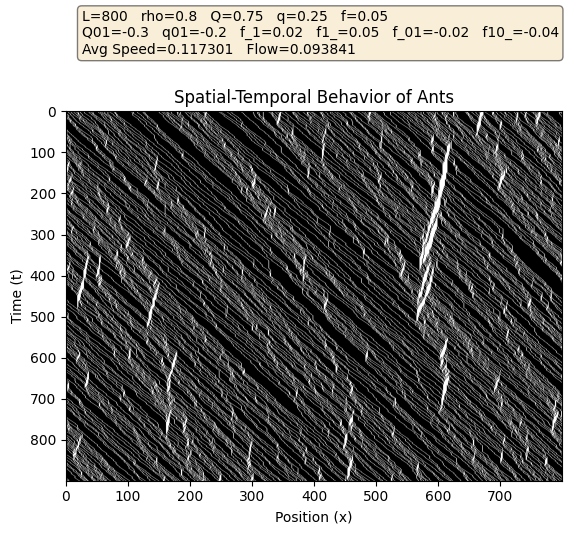

In [176]:
plot = True
L, rho, Q, q, f = 800, .8, 0.75, 0.25, 0.05
Q01, q01, f_1, f1_, f_01, f10_ = -0.3, -0.2, 0.02, 0.05, -0.02, -0.04
test = ATM_v2(L, rho, Q, q, f, Q01, q01, f_1, f1_, f_01, f10_)
test.simulate(200, 700, plot)

// comments of above graphs

Now let's plot some other graphs to see how some of these new parameters change flow and velocity

C:\Users\test1\AppData\Local\Temp\ipykernel_22880\3212136487.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  itr_spd[i] = self._compute_avg_spd()


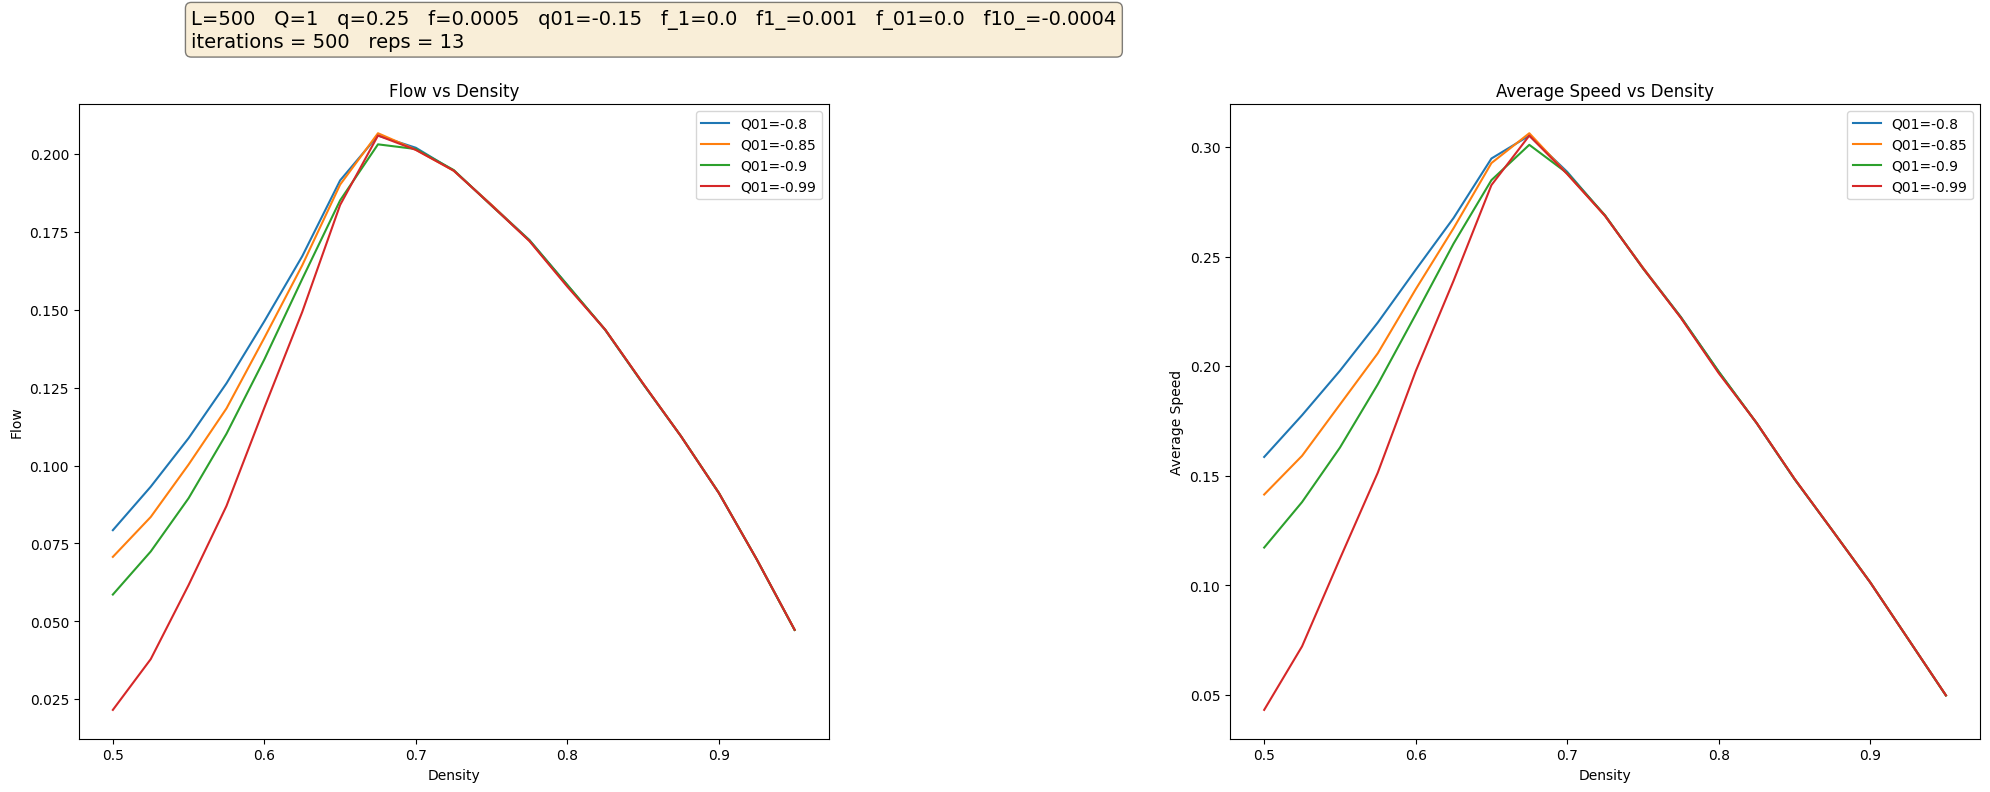

In [3]:
#primi due grafici del paper
test_Q01 = np.array([-0.8, -0.85, -0.9, -0.99])
test_rho = np.linspace(0.5, 0.95, 19)
plot = False
L, Q, q, f = 500, 1, 0.25, 0.0005
q01, f_1, f1_, f_01, f10_ = -0.15, 0.0, 0.001, 0.0, -0.0004 # q01=0.2
setup, iterations, reps = 0, 500, 13

data = np.empty(shape=(2, len(test_rho) * len(test_Q01)))
tmp = np.empty(shape=(2, reps))
for i,Q01 in enumerate(test_Q01):
    for j,rho in enumerate(test_rho):
        for k in range(reps): # "anti-aliasing"
            model = ATM_v2(L, rho, Q, q, f, Q01, q01, f_1, f1_, f_01, f10_)
            model.simulate(setup, iterations, plot)
            tmp[0,k] = model._flow
            tmp[1,k] = model._avg_speed
        data[0, j + len(test_rho) * i] = sum(tmp[0,:])/reps
        data[1, j + len(test_rho) * i] =  sum(tmp[1,:])/reps

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for i, Q01 in enumerate(test_Q01):
    ax1.plot(test_rho, data[0, i*len(test_rho):(i+1)*len(test_rho)], label=f'Q01={Q01}')
    ax2.plot(test_rho, data[1, i*len(test_rho):(i+1)*len(test_rho)], label=f'Q01={Q01}')

ax1.set_xlabel('Density')
ax1.set_ylabel('Flow')
ax1.set_title('Flow vs Density')
ax1.legend()

ax2.set_xlabel('Density')
ax2.set_ylabel('Average Speed')
ax2.set_title('Average Speed vs Density')
ax2.legend()

textstr = f'L={L}   Q={Q}   q={q}   f={f}   q01={q01}   f_1={f_1}   f1_={f1_}   f_01={f_01}   f10_={f10_}\niterations = {setup + iterations}   reps = {reps}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.15, 1.15, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

C:\Users\test1\AppData\Local\Temp\ipykernel_22880\3212136487.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  itr_spd[i] = self._compute_avg_spd()


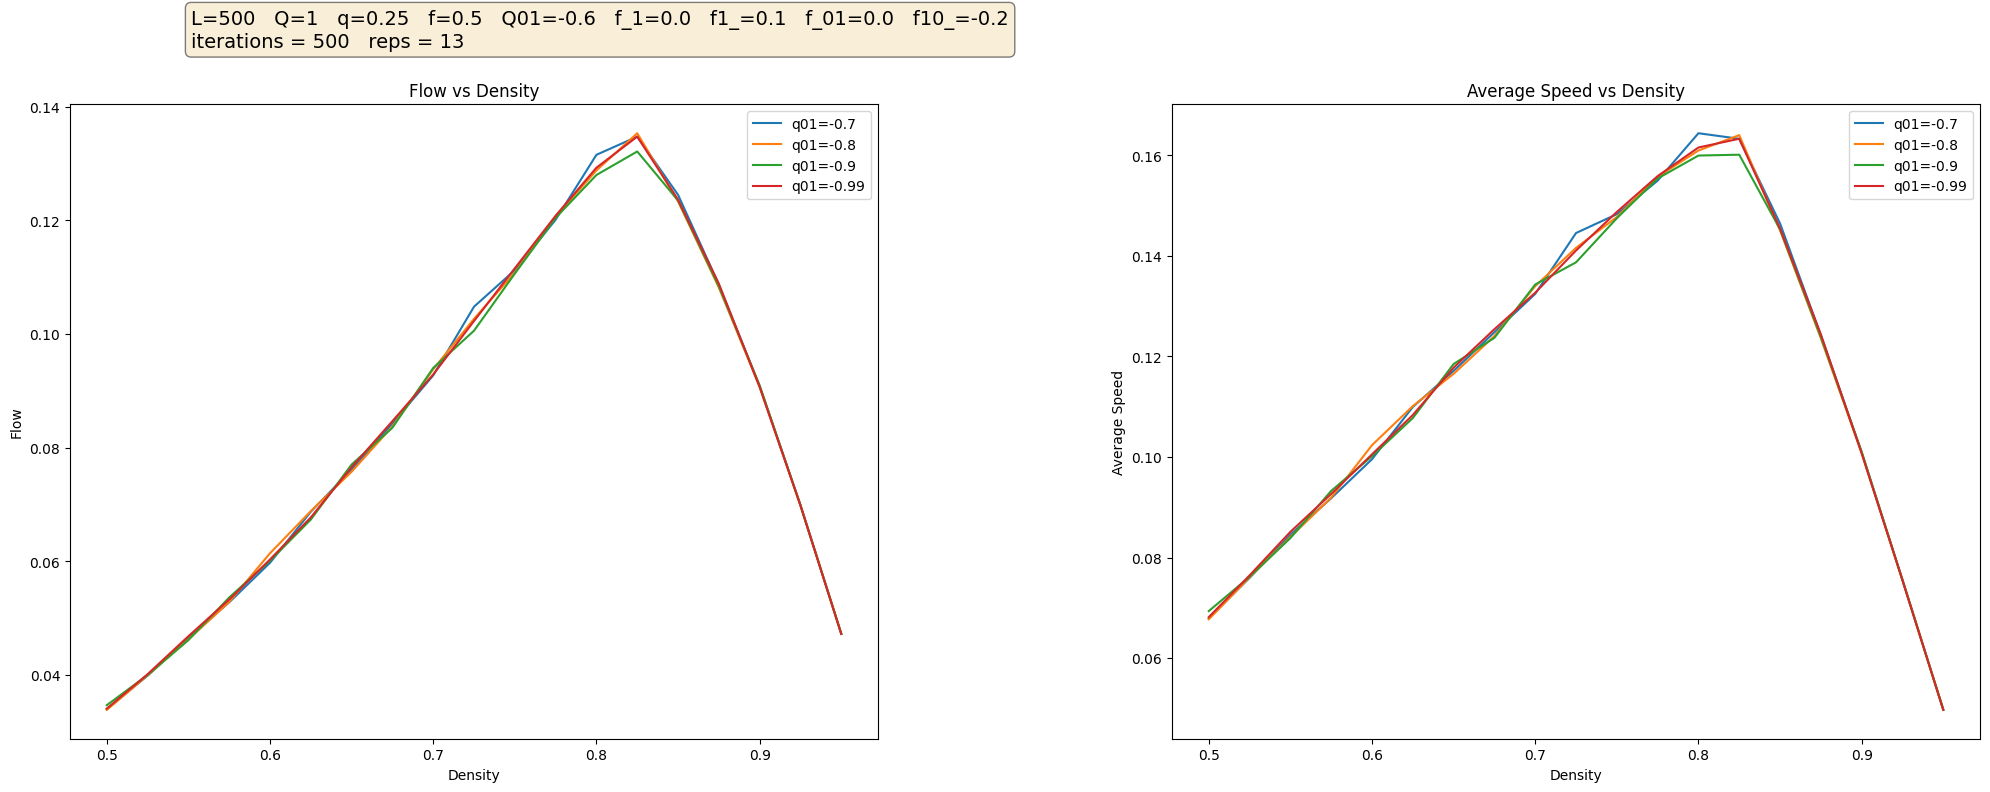

In [4]:
#terza coppia di grafici del paper
test_q01 = np.array([-0.7, -0.8, -0.9, -0.99])
test_rho = np.linspace(0.5, 0.95, 19)
plot = False
L, Q, q, f = 500, 1, 0.25, 0.5
Q01, f_1, f1_, f_01, f10_ = -0.6, 0.0, 0.1, 0.0, -0.2
setup, iterations, reps = 0, 500, 13

data = np.empty(shape=(2, len(test_rho) * len(test_q01)))
tmp = np.empty(shape=(2, reps))
for i,q01 in enumerate(test_q01):
    for j,rho in enumerate(test_rho):
        for k in range(reps): # "anti-aliasing"
            model = ATM_v2(L, rho, Q, q, f, Q01, q01, f_1, f1_, f_01, f10_)
            model.simulate(setup, iterations, plot)
            tmp[0,k] = model._flow
            tmp[1,k] = model._avg_speed
        data[0, j + len(test_rho) * i] = sum(tmp[0,:])/reps
        data[1, j + len(test_rho) * i] =  sum(tmp[1,:])/reps

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for i, q01 in enumerate(test_q01):
    ax1.plot(test_rho, data[0, i*len(test_rho):(i+1)*len(test_rho)], label=f'q01={q01}')
    ax2.plot(test_rho, data[1, i*len(test_rho):(i+1)*len(test_rho)], label=f'q01={q01}')

ax1.set_xlabel('Density')
ax1.set_ylabel('Flow')
ax1.set_title('Flow vs Density')
ax1.legend()

ax2.set_xlabel('Density')
ax2.set_ylabel('Average Speed')
ax2.set_title('Average Speed vs Density')
ax2.legend()

textstr = f'L={L}   Q={Q}   q={q}   f={f}   Q01={Q01}   f_1={f_1}   f1_={f1_}   f_01={f_01}   f10_={f10_}\niterations = {setup + iterations}   reps = {reps}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.15, 1.15, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

C:\Users\test1\AppData\Local\Temp\ipykernel_23712\3212136487.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  itr_spd[i] = self._compute_avg_spd()


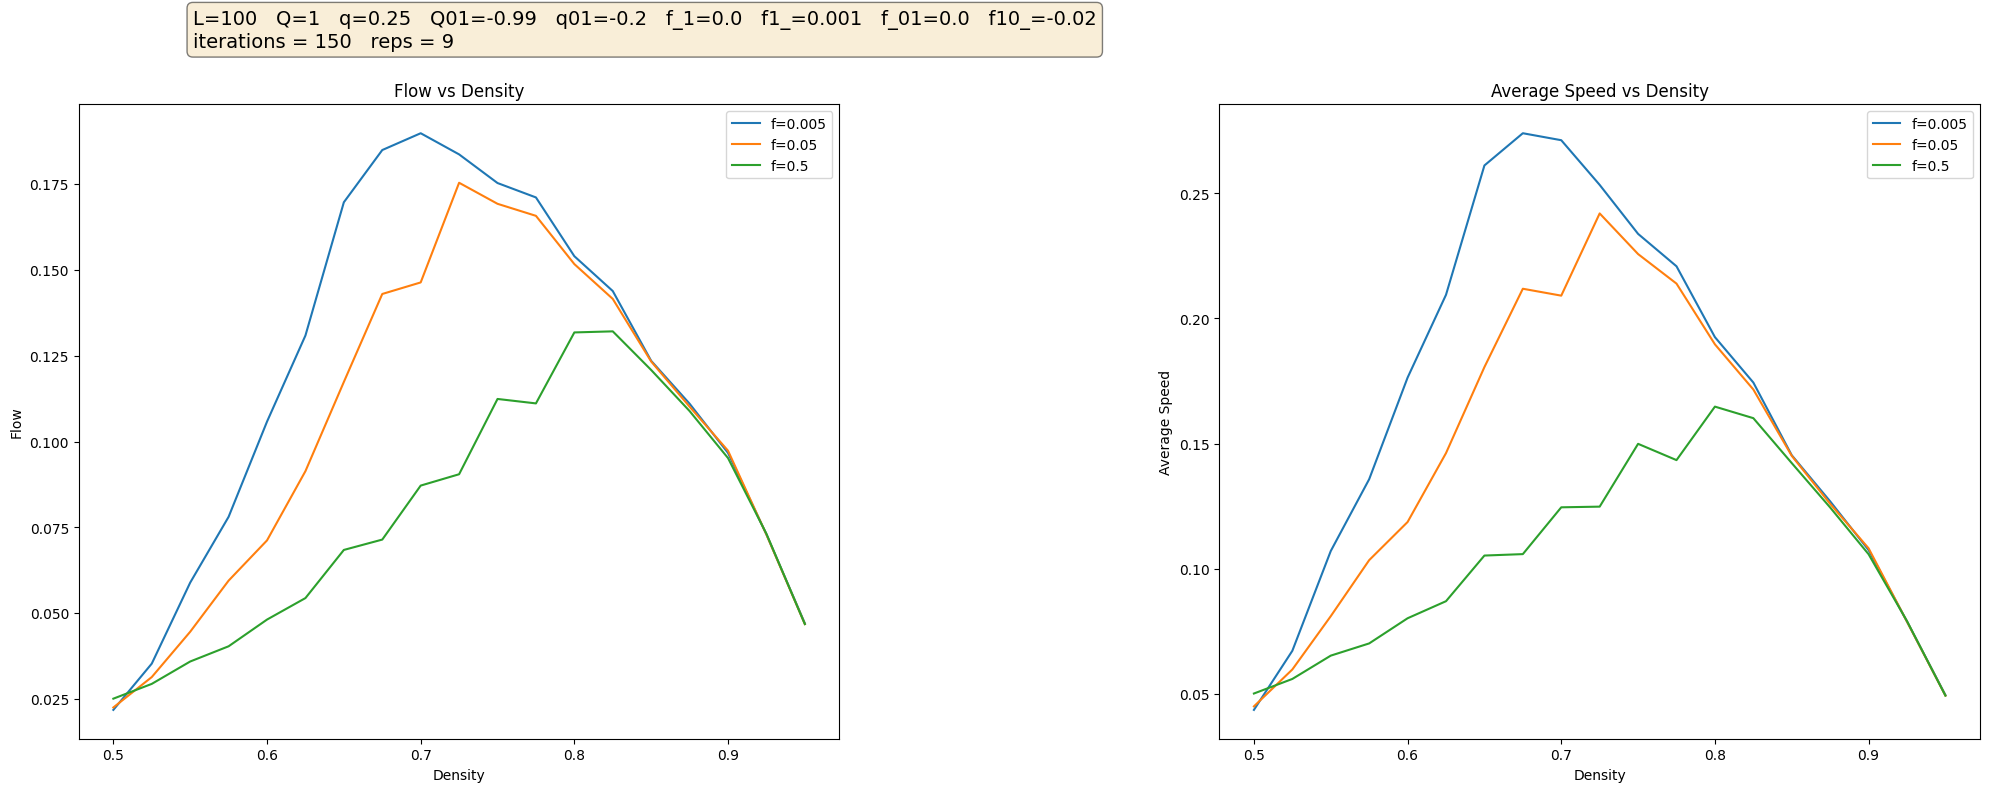

In [ ]:
#quinta coppia di grafici del paper
test_f = np.array([0.005, 0.05,0.5])
test_rho = np.linspace(0.5, 0.95, 19)
plot = False
L, Q, q = 500, 1, 0.25
Q01, q01, f_1, f1_, f_01, f10_ = -0.99, -0.2, 0.0, 0.001, 0.0, -0.02
setup, iterations, reps = 0, 500, 9

data = np.empty(shape=(2, len(test_rho) * len(test_f)))
tmp = np.empty(shape=(2, reps))
for i,f in enumerate(test_f):
    for j,rho in enumerate(test_rho):
        for k in range(reps): # "anti-aliasing"
            model = ATM_v2(L, rho, Q, q, f, Q01, q01, f_1, f1_, f_01, f10_)
            model.simulate(setup, iterations, plot)
            tmp[0,k] = model._flow
            tmp[1,k] = model._avg_speed
        data[0, j + len(test_rho) * i] = sum(tmp[0,:])/reps
        data[1, j + len(test_rho) * i] =  sum(tmp[1,:])/reps

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for i, f in enumerate(test_f):
    ax1.plot(test_rho, data[0, i*len(test_rho):(i+1)*len(test_rho)], label=f'f={f}')
    ax2.plot(test_rho, data[1, i*len(test_rho):(i+1)*len(test_rho)], label=f'f={f}')

ax1.set_xlabel('Density')
ax1.set_ylabel('Flow')
ax1.set_title('Flow vs Density')
ax1.legend()

ax2.set_xlabel('Density')
ax2.set_ylabel('Average Speed')
ax2.set_title('Average Speed vs Density')
ax2.legend()

textstr = f'L={L}   Q={Q}   q={q}   Q01={Q01}   q01={q01}   f_1={f_1}   f1_={f1_}   f_01={f_01}   f10_={f10_}\niterations = {setup + iterations}   reps = {reps}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.15, 1.15, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()